In [1]:
import os
import numpy as np
import torch
from franka import Franka
from omegaconf import OmegaConf
from models import get_model
from loader import get_dataloader
from utils import Kinematics_numpy
from tqdm import tqdm
from utils.visualization import SE3_Trajectory_Visualization
from utils import LieGroup_numpy
from utils.utils import mkdir_p
from models.groups import PouringGroup
import random
import sys
sys.path.append('../../')
from metrics import SE3_trajectory_distance, Encoder_invariance
import matplotlib.pyplot as plt
device = 'cpu'

%matplotlib widget
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

def compute_mean_SE3(SE3_traj, n_iter=300, step_size=0.01):
    T_mean = np.eye(4, 4)
    p_mean = np.mean(SE3_traj[:, :3, 3], axis=0)
    Rs = SE3_traj[:, :3, :3]
    R_opt = np.eye(3, 3)
    for _ in range(n_iter):
        RinvR = np.expand_dims(np.transpose(R_opt), axis=0)@Rs
        grad = []
        for rinvr in RinvR:
            grad.append(LieGroup_numpy.log_SO3(rinvr))
        grad = np.sum(np.array(grad), axis=0)
        grad = grad/np.linalg.norm(grad)
        R_opt = R_opt@LieGroup_numpy.exp_so3(step_size * grad)
        
    R_mean = R_opt
    T_mean[:3, 3] = p_mean
    T_mean[:3, :3] = R_mean
    return T_mean[:3]

def SE3_Moving_Average(SE3_traj, window_size=7):
    # SE3_traj = SE3_traj[1:]
    time_step = len(SE3_traj)
    avg_traj = np.zeros_like(SE3_traj)

    for i in tqdm(range(time_step)):
        if i == 0:
            avg_traj[i] = SE3_traj[i]
        elif (i < window_size) and (i > 0):
            avg_traj[i] = compute_mean_SE3(SE3_traj[:i+1])
        else:
            avg_traj[i] = compute_mean_SE3(SE3_traj[i-window_size+1:i+1])
    return avg_traj

def joint_traj_Moving_Average(joint_traj, window_size=15):
    '''joint_traj: time_step X 7'''
    time_step = joint_traj.shape[0]
    avg_traj = np.zeros_like(joint_traj)

    for i in range(time_step):
        if i == 0:
            avg_traj[i] = joint_traj[i]
        elif (i < window_size) and (i > 0):
            avg_traj[i] = np.mean(joint_traj[:i+1], axis=0)
        else:
            avg_traj[i] = np.mean(joint_traj[i-window_size+1:i+1], axis=0)
    return avg_traj


/home/robotics/anaconda3/envs/HarmonicAE/lib/python3.8/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [2]:
xml_root = ''
franka_xml_path = os.path.join(xml_root, 'franka_panda_robot_only_cat.xml')
franka_model = Franka(franka_xml_path)

In [3]:
group = PouringGroup()

# the number of trajetcories to generate
num_data = 1
position_scale = 0.5
z = torch.randn(num_data, 1)

r = torch.rand(num_data) * 0.3 + 0.45
h = torch.rand(num_data) * 0.2 + 0.4
w = torch.zeros(num_data, 6)
w[:, 2] = r
w[:, 4] = h

p_c = torch.rand(num_data, 2) * position_scale - 0.5 * position_scale
theta = torch.rand(num_data, 2) * (2 * np.pi)
g = torch.cat((p_c, theta), dim=1)

w = group.action_task(g, w)

100%|██████████| 270/270 [00:25<00:00, 10.55it/s]


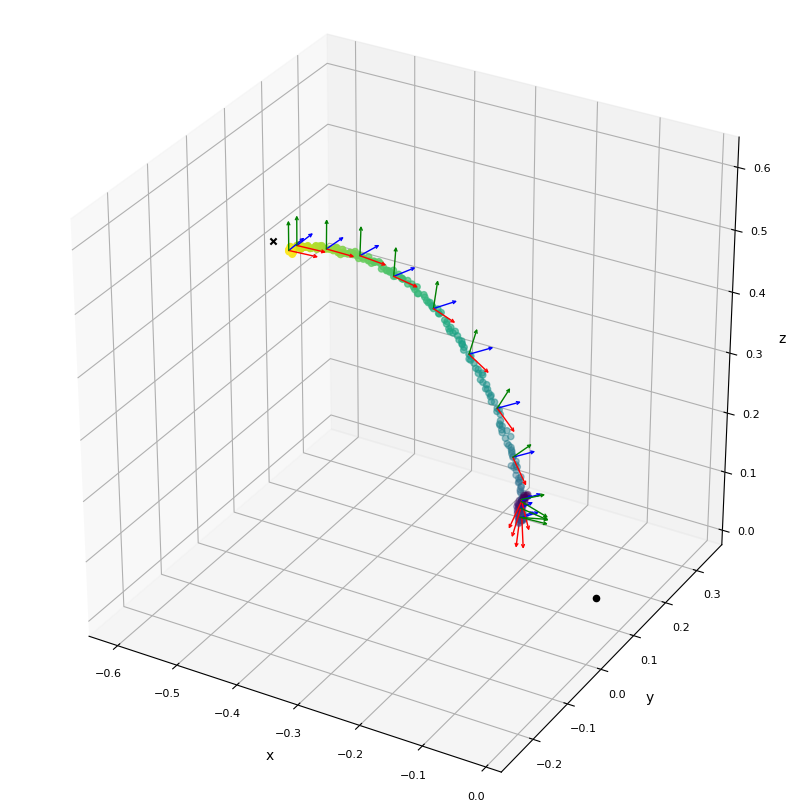

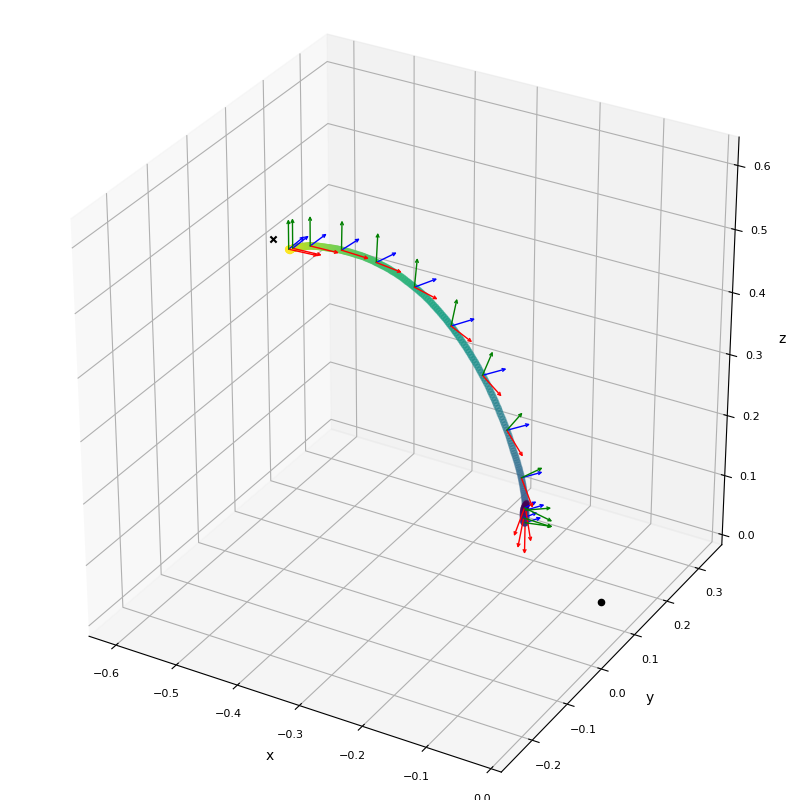

In [5]:
# model_name = "TCVAE"
model_name = "equivariant_TCVAE"

# cfg_path = 'results/Pouring/TCVAE/DIM_1/Pouring_TCVAE_512512/TCVAE.yml'
# ckfg_path = 'results/Pouring/TCVAE/DIM_1/Pouring_TCVAE_512512/model_best.pkl'
cfg_path = '../results/Pouring/equivariant_TCVAE/DIM_1/Pouring_equiTCVAE_3232/equivariant_TCVAE.yml'
ckfg_path ='../results/Pouring/equivariant_TCVAE/DIM_1/Pouring_equiTCVAE_3232/model_best.pkl'

cfg = OmegaConf.load(cfg_path)
model = get_model(cfg).to(device)
model.load_state_dict(torch.load(ckfg_path, map_location=device)['model_state'])

hat_x = model.decode(z, w)
time_step = int(hat_x.size()[1]/12)
hat_x = hat_x.reshape(num_data, time_step, 3, 4)

# Smoothing Trajectory
x = []
for i in range(num_data):
    x.append(torch.tensor(SE3_Moving_Average(SE3_traj=hat_x[i].detach().numpy(), window_size=25), dtype=torch.float32).unsqueeze(0))
x = torch.cat(x, dim=0)

idx = 0
fig1 = SE3_Trajectory_Visualization(traj=hat_x[idx, :, :3, :], task=w[idx])
fig2 = SE3_Trajectory_Visualization(traj=x[idx, :, :3, :], task=w[idx])

In [6]:
group = PouringGroup()
g = group.project_group(w)
w_0, x_0 = group.action_traj(g, w, x)
x_0 = x_0.reshape(num_data, time_step, 3, 4)

temp = torch.zeros((num_data, time_step, 1, 4))
temp[:, :, :, 3] = 1
x_aug = torch.cat((x_0, temp), dim=2)

# End-effector <-> Cup 
theta = torch.ones(time_step) * (np.pi/2)
rot1 = group.rot_z(theta=theta).unsqueeze(0).repeat(num_data, 1, 1, 1)
rot2 = torch.tensor([[0, 0, 1, 0],[0, -1, 0, 0],[1, 0, 0, 0],[0, 0, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(num_data, time_step, 1, 1)
rot3 = torch.tensor([[1, 0, 0, 0], [0, 0, 1, 0], [0, -1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(num_data, time_step, 1, 1)
traj = rot1 @ x_aug @ rot2 @ rot3
traj[:, :, :3, 3] = traj[:, :, :3, 3] + torch.tensor([0.6, -0.4, 0.25+0.05]) # Set cup position on table

In [7]:
joint_limit = [
    [-2.8973, 2.8973],
    [-1.7628, 1.7628],
    [-2.8973, 2.8973],
    [-3.0718, -0.0698],
    [-2.8973, 2.8973],
    [-0.0175, 3.7525],
    [-2.8973, 2.8973],
]

# the number of IK solution
num_IK = 1
t_via = np.linspace(0, 9, 270)
for idx_data in range(num_data):
    T_traj_via = traj[idx_data].detach().numpy()
    count = 0
    for num in tqdm(range(num_IK)):
        q_init = [-1.91413255, -1.40266464,  0.6533821 , -1.18612957,  1.71732091, 2.22385606,  0.85433674] + np.random.randn(7) * 0.5 #random
        # q_init = [-2.0057030425573648, -1.552928994346083, 0.7110544694766664, -1.4998763583380144, 0.5, 0.5, 0.5] # manually obtained 1
        # q_init = [-2.0057030425573648, -1.552928994346083, 0.7110544694766664, -1.4998763583380144, 2.04421532477604, 2.240111422960053, 0.5090758493349987] # manually obtained 1
        # q_init = [-1.2743258014917371, -0.9797194011755155, 1.1528589829073526, -1.7797570616404212, 1.7625199890487084, 2.852610510773129, -0.011556249000265523] # manually obtained 2
        # q_init = [-0.48230601, -0.39131458, -0.05519465, -0.52731423, 0.41012392, 0.23156516, 0.13954788] # best 1 final
        # q_init = [-1.91413255, -1.40266464,  0.6533821 , -1.18612957,  1.71732091, 2.22385606,  0.85433674] # best 3 initial ##best of best!
        print(f"Data : {idx_data+1}, Iter: {num+1}, Randomly selected q_init is {q_init}")
        q_traj_via = []
        q_traj_via.append(q_init)
        # for i in reversed(range(len(T_traj_via))):
        for i in range(len(T_traj_via)):
            q_traj_via.append(Kinematics_numpy.inverse_kinematics(
            franka_model.initialEEFrame,
            T_traj_via[i].copy(),
            q_traj_via[-1].copy(),
            franka_model.S_screw,
            B_screw=franka_model.B_screw,
            show=False,
            max_iter=200,
            tolerance=0.0001,
            step_size=0.01,
            step_size2=0.0001,
            step_size3=0,
            joint_limit=franka_model.joint_limit,
            singular_avoidance=False # True
        ))
        q_traj_via = np.concatenate([q.reshape(1, 7) for q in q_traj_via[1:]], axis=0)
        smoothed_q_traj_via = joint_traj_Moving_Average(q_traj_via, window_size=15)
        
        # if num < 10:
        #     ax = fig3.add_subplot(2, 5, num+1)
        #     for joint in range(7):
        #         ax.plot(t_via, smoothed_q_traj_via[:, joint], label=joint)
        #     plt.legend()
        
        temp = True
        for joint in range(7):
            bool_list = ((smoothed_q_traj_via[:,joint]) < joint_limit[joint][1]) * ((smoothed_q_traj_via[:,joint]) > joint_limit[joint][0])
            for i in range(q_traj_via.shape[0]):
                temp *= (bool_list[i])
                
        if not temp:
            print("joint limit violated")
            np.save(f'q_traj_via_{count}.npy', smoothed_q_traj_via)
            
        else:
            count += 1
            print(f"Count: {count}, joint limit is not violated")
            path = f'IK_solution/{model_name}/data_{idx_data+1+20}/'
            mkdir_p(path)
            q_path = path + f'q_traj_via_{count}.npy'
            q_init_path = path + f'q_init_{count}.npy'
            task_path = path + f'w_{count}.npy'
            
            np.save(q_path, smoothed_q_traj_via)
            np.save(q_init_path, q_init)
            np.save(task_path, w[idx_data].detach().numpy())
        

  0%|          | 0/1 [00:00<?, ?it/s]

Data : 1, Iter: 1, Randomly selected q_init is [-1.73402244 -1.19533968  1.20320541 -1.42266899  2.41562214  2.54661603
 -0.02412583]


100%|██████████| 1/1 [00:19<00:00, 19.63s/it]

joint limit violated
